# Projet numérique de Science des Données 2025

__Binôme numéro 55 -- VANDERSIPPE Gabriel et DELTOUR Arnaud__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

**Réponse :** Cela permet d'avoir une idée du risque obstétrique dans ces régions, sans avoir à y conduire des études de terrain, onéreuses et chronophages. Toutefois, c'est un modèle extrêmement simplifié de la réalité, qui néglige de nombreux aspects de la réalité. Il faut garder en tête que c'est un outil qui est utile pour avoir une estimation rapide, mais celle-ci reste dans une certaine mesure floue, et peut ne pas refléter la réalité du terrain, elle est donc à manier avec précaution.

## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('donnees_entrainement.csv')
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [3]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

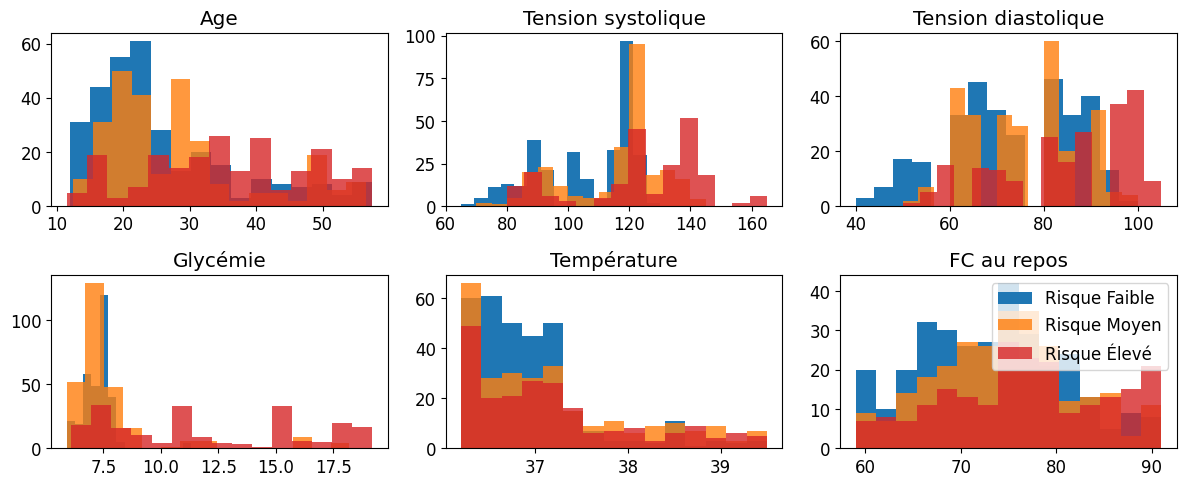

In [4]:
fig = plt.figure(figsize=(12, 5))

for (feat_idx, feat_name) in enumerate(df_train.columns[:6]):
    ax = fig.add_subplot(2, 3, (feat_idx+1))

    h = ax.hist(df_train[df_train['Risque']==0][feat_name], bins=15,  
                color='tab:blue', edgecolor='none', alpha=1, label='Risque Faible')
    
    h = ax.hist(df_train[df_train['Risque']==1][feat_name], bins=15,  
                color='tab:orange', edgecolor='none', alpha=0.8, label='Risque Moyen')

    h = ax.hist(df_train[df_train['Risque']==2][feat_name], bins=15,  
                color='tab:red', edgecolor='none', alpha=0.8, label='Risque Élevé')

    ax.set_title(feat_name)

plt.legend()

fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

**Réponse :**

Pour l'âge, on remarque qu'être plus âgé augemente drastiquement le risque obstétrique. \
Pour la tension, lorsque l'on s'éloigne de la valeur normale, on remarque qu'un risque élevé, en rouge, devient plus important. \
Idem pour la glycémie, un taux élevé implique un fort risque. \
Pour la température, l'effet est moins visible. \
Pour la fréquence cardiaque, c'est assez étalé pour tous les risques.

Ces résultats sont cohérents avec ce que l'on pouvait attendre, des valeurs éloignées de la moyenne en bonne santé conduisent à une élévation du risque obstétrique.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

**Réponse :**

Cela paraît peu aisé, car, mis à part l'âge et éventuellement la glycémie, on distingue peu de différences dans les distributions à première vue. Toutefois, il y a peu de variables, donc on peut espérer ne pas avoir à faire face au fléau de la dimension, ce qui pourrait éventuellement nous aider à prédire le risque.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

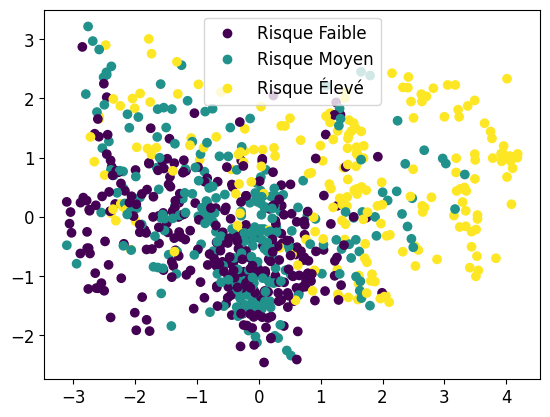

In [56]:
from sklearn import decomposition
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
scatter = plt.scatter(X_projected[:,0], X_projected[:,1], c=y_train, marker = 'o')

plt.legend(handles=scatter.legend_elements()[0], labels=["Risque Faible","Risque Moyen","Risque Élevé"])

plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

**Réponse :**

Non car les données sont fortement mélangées, comme nous pouvons le voir sur le graphique qui précède. Le risque élevé se détache légèrement des autres, mais cela reste marginal et ne nous permet pas de trancher immédiatement.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

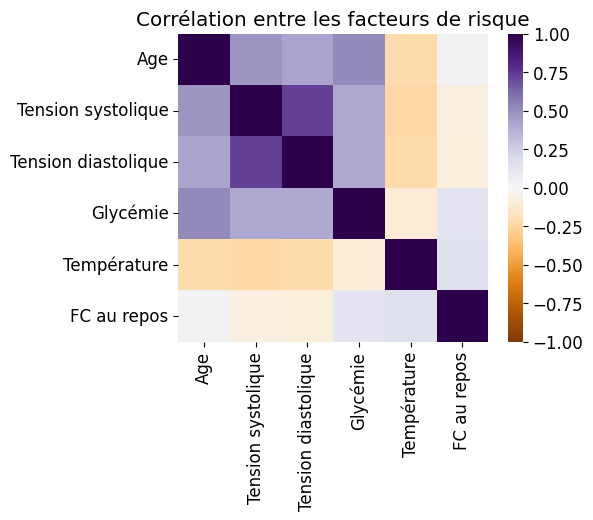

In [6]:
import seaborn as sns

corr_matrix = df_train.drop(columns="Risque").corr()

plt.figure(figsize=(5, 4))

sns.heatmap(corr_matrix,vmin=-1,vmax=1, center= 0, cmap='PuOr')

plt.title("Corrélation entre les facteurs de risque")
plt.show()

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

**Réponse :**

On peut réduire sur les dimensions fortement corrélées, car elles contiennent les mêmes informations et donc sont redondantes. Par exemple ici, on peut ne  conserver que la tension systolique ou diastolique. En revanche, contrairement à la réduction de dimension précédente, les axes n'ont pas été optimisés.


# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [7]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_binary = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

df_train_risk_vs_norisk.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,1
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [8]:
res = df_train_risk_vs_norisk["Risque"].value_counts()
res.get(1)/(res.get(1)+res.get(0))

np.float64(0.605)

**Réponse :**
Le code ci-dessus nous permet d'observer que 60.5% des lignes sont des lignes assiociées à un risque de type 1. Ainsi, si toutes les observations sont étiquetées "1", qui est la classe majoritaire, on aurait une proportion de 60.5% d'observations correctement étiquetées.

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

**Réponse :**

L'accuracy de la question précédente est définie de la manière suivante :

$$
\frac{\text{TP}}{\text{TP}+\text{FP}}
$$

Soit la quantité de vrais positifs sur la quantité d'observation marquées positives. 

Pour le balanced accuracy, on fait la moyenne entre la proportion de vrais positifs sur la quantité réelle de positifs, et de vrais négatifs sur la quantité réelle de vrais négatifs. Ce qui traduit mieux la réalité puisque l'on prend en compte la notion de faux négatifs.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

**Réponse :**

Il n'y a pas d'entraînement à proprement parler, simplement un stockage des données qui serviront d'échantillons avec leurs étiquettes.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

**Réponse :**

On s'attend à une précision de 1, étant donné qu'il a été entraîné sur ce jeu là, et que par conséquent il en connaît les étiquettes ; si on utilise un algorithme du plus proche voisin, comme le plus proche voisin d'une donnée d'entraînement est lui-même, il retournera toujours la bonne étiquette.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

Pécision équilibrée: 1.00


c:\miniconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


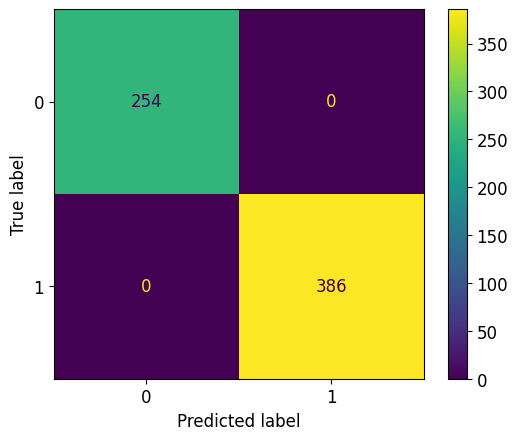

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, model_selection

# Suppression des étiquettes sur les données d'entrainement
X_train_binary = std_scale.transform(df_train_risk_vs_norisk.drop(columns=['Risque']).copy())
y = y_train_binary.copy()

#On sépare les données d'entraînement en un jeu de test et un jeu d'entraînement
x_train_risk_vs_norisk, x_test_risk_vs_norisk, y_train_risk_vs_norisk, y_test_risk_vs_norisk = model_selection.train_test_split(X_train_binary, y, test_size = 0.2, random_state=1)


# Phase d'entrainement
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_train_risk_vs_norisk, y_train_risk_vs_norisk)

# Prédiction des étiquettes
y_pred = neigh.predict(x_train_risk_vs_norisk)

# Calcul de la précision équilibrée
print(f"Pécision équilibrée: {metrics.balanced_accuracy_score(y_train_risk_vs_norisk, y_pred):.2f}")

# Visualisation des prédictions
metrics.ConfusionMatrixDisplay.from_predictions(y_train_risk_vs_norisk, y_pred)
plt.show()

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

**Réponse :** Pour cet algorithme, il vaut mieux utiliser des données centrées réduites, car il mesure la distance euclidienne entre les points, qui est donc impactée par les valeurs prises par les données.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Meilleur K : 47
Pécision équilibrée: 0.7534561403508772


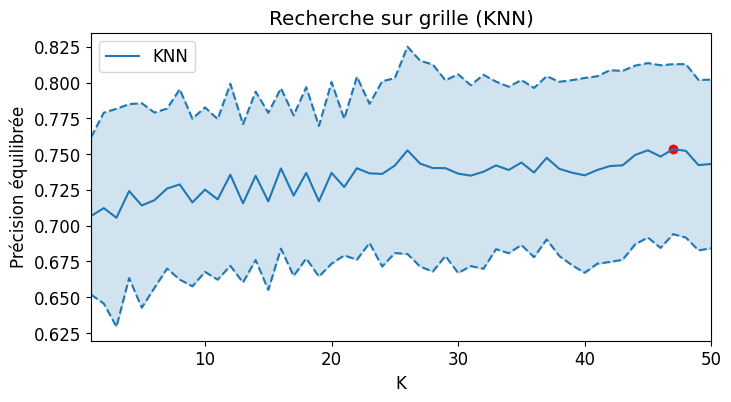

In [58]:
from sklearn import model_selection

# Définir la grille de valeurs de l'hyperparamètre K 
K = np.linspace(1, 50, 50, dtype=np.int64)

neigh = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(neigh, {'n_neighbors': K}, 
                                    cv=10, # on utilise 10 folds
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(x_train_risk_vs_norisk, y_train_risk_vs_norisk)



## Affichage sur un graphique des résultats

plt.figure(figsize=(8, 4))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.plot(grid.cv_results_['param_n_neighbors'], precision, 
             label="KNN", color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(K, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

plt.scatter(grid.best_params_['n_neighbors'], grid.best_score_, marker = 'o', c='red')
print(f"Meilleur K : {grid.best_params_['n_neighbors']}")
print(f"Pécision équilibrée: {grid.best_score_}")

# Mise en forme
plt.xlabel("K")
plt.ylabel("Précision équilibrée")
plt.xlim([K[0], K[-1]])
plt.title("Recherche sur grille (KNN)")
plt.legend(loc='best')
plt.show()

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Meilleure constante : 0.6250551925273969
Pécision équilibrée: 0.6625721997300944


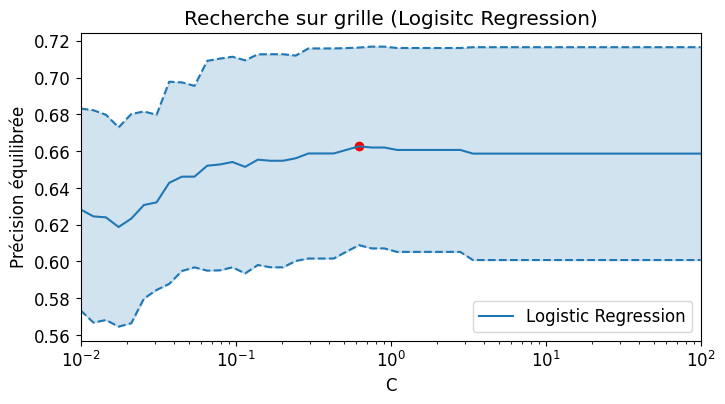

In [61]:
from sklearn import model_selection,linear_model

# Définir la grille de valeurs de l'hyperparamètre C 
Coefficients = np.logspace(-2, 2, 50)

logregress = linear_model.LogisticRegression(max_iter=10000)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(logregress, {'C': Coefficients}, 
                                    cv=10, # on utilise 10 folds
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(x_train_risk_vs_norisk, y_train_risk_vs_norisk)



## Affichage sur un graphique des résultats

plt.figure(figsize=(8, 4))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les précisions avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid.cv_results_['param_C'], precision, 
             label="Logistic Regression", color='tab:blue')
plt.semilogx(grid.cv_results_['param_C'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_C'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(Coefficients, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

plt.scatter(grid.best_params_['C'], grid.best_score_, marker = 'o', c='red')
print(f"Meilleure constante : {grid.best_params_['C']}")
print(f"Pécision équilibrée: {grid.best_score_}")


# Mise en forme
plt.xlabel("C")
plt.ylabel("Précision équilibrée")
plt.xlim([Coefficients[0], Coefficients[-1]])
plt.title("Recherche sur grille (Logisitc Regression)")
plt.legend(loc='best')
plt.show()

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

Meilleur N : 96
Pécision équilibrée: 0.8094669365721996


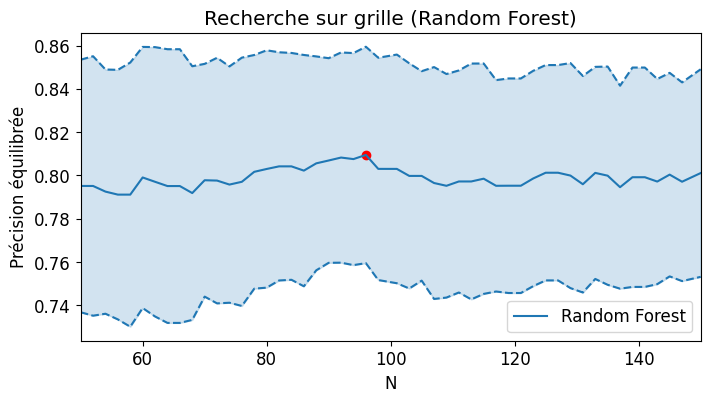

In [62]:
from sklearn import model_selection, ensemble

# Définir la grille de valeurs de l'hyperparamètre N
N = np.linspace(50, 150, 50, dtype=np.int64)

rforest = ensemble.RandomForestClassifier(random_state=46)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(rforest, {'n_estimators': N}, 
                                    cv=10, # on utilise 10 folds
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(x_train_risk_vs_norisk, y_train_risk_vs_norisk)



## Affichage sur un graphique des résultats

plt.figure(figsize=(8, 4))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.plot(grid.cv_results_['param_n_estimators'], precision, 
             label="Random Forest", color='tab:blue')
plt.plot(grid.cv_results_['param_n_estimators'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_estimators'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(N, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

plt.scatter(grid.best_params_['n_estimators'], grid.best_score_, marker = 'o', c='red')
print(f"Meilleur N : {grid.best_params_['n_estimators']}")
print(f"Pécision équilibrée: {grid.best_score_}")


# Mise en forme
plt.xlabel("N")
plt.ylabel("Précision équilibrée")
plt.xlim([N[0], N[-1]])
plt.title("Recherche sur grille (Random Forest)")
plt.legend(loc='best')
plt.show()

On choisit d'évaluer le nombre d'arbres aléatoires que l'on veut pour la régression. On observe toutefois très peu de variabilité dues à autre chose que du bruit sur le graphique des résultats, ainsi on a plutôt intérêt à prendre un petit nombre d'arbres, qui a presque la même précision mais est bien moins coûteux en calculs.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

**Réponse :**

L'algorithme le plus performant est celui de la forêt aléatoire, avec une précision équilibrée pour le meilleur modèle de 0,81. On remarque que de surcroît, comme mentionné ci-dessus, cette performance semble être assez constante quel que soit le nombre d'arbres choisi, ce qui en fait un algorithme très adapté à la résolution de ce problème.

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

In [66]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

X_train_projected, X_test_projected, y_train_projected, y_test_projected = model_selection.train_test_split(X_projected, y_train_binary, test_size=0.2, random_state=1)

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

Meilleur N : 121
Pécision équilibrée: 0.6547112010796221


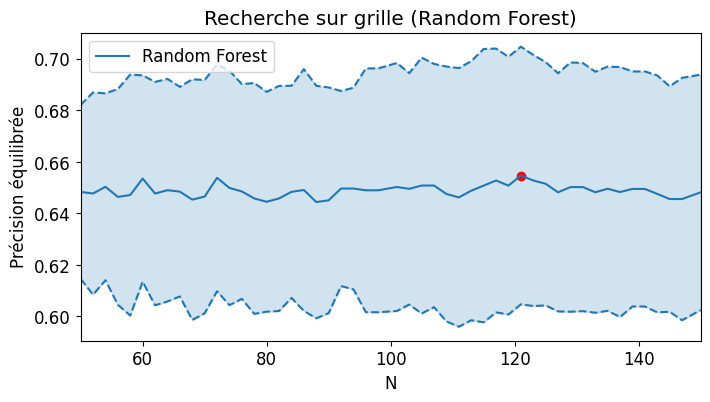

In [67]:
from sklearn import model_selection, ensemble

# Définir la grille de valeurs de l'hyperparamètre N
N = np.linspace(50, 150, 50, dtype=np.int64)

rforest = ensemble.RandomForestClassifier(random_state=46)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(rforest, {'n_estimators': N}, 
                                    cv=10, # on utilise 10 folds
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_projected, y_train_projected)



## Affichage sur un graphique des résultats

plt.figure(figsize=(8, 4))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.plot(grid.cv_results_['param_n_estimators'], precision, 
             label="Random Forest", color='tab:blue')
plt.plot(grid.cv_results_['param_n_estimators'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_estimators'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(N, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

plt.scatter(grid.best_params_['n_estimators'], grid.best_score_, marker = 'o', c='red')
print(f"Meilleur N : {grid.best_params_['n_estimators']}")
print(f"Pécision équilibrée: {grid.best_score_}")


# Mise en forme
plt.xlabel("N")
plt.ylabel("Précision équilibrée")
plt.xlim([N[0], N[-1]])
plt.title("Recherche sur grille (Random Forest)")
plt.legend(loc='best')
plt.show()

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

**Réponse :**

On voit que la précision est toujours environ constante en dépit de la variation du nombre d'arbres ; elle est en revanche bien plus basse que l'équivalent sans réduction de dimension. On en déduit donc qu'on a ici perdu au change, et qu'il est dans notre intérêt, du moins au vu de ce résultat, de conserver toutes les données.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

In [72]:
final_binary_classifier = ensemble.RandomForestClassifier(n_estimators=96)
final_binary_classifier.fit(x_train_risk_vs_norisk,y_train_risk_vs_norisk)

RandomForestClassifier(n_estimators=96)

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [73]:
# Récupération des données de test
df_reservees = pd.read_csv('donnees_reservees.csv')

# Préparation des données de test
df_reservees_risk_vs_norisk = df_reservees.copy()
df_reservees_risk_vs_norisk['Risque'] = np.where(df_reservees['Risque']==2, 1, df_reservees['Risque'])
X_reservees = df_reservees_risk_vs_norisk.drop(columns=['Risque'])
y_reservees = np.array(df_reservees_risk_vs_norisk['Risque'], dtype='int')

X_reservees_scaled = std_scale.transform(X_reservees)

c:\miniconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [74]:
y_pred_final = final_binary_classifier.predict(X_reservees_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [75]:
metrics.balanced_accuracy_score(y_reservees, y_pred_final)

np.float64(0.8239086387916743)

**Réponse :**

La précision est encore meilleure que celle obtenue sur les données utilisées lors de la sélection du modèle. Ceci peut s'expliquer par le fait que l'on a utilisé qu'une fraction des données d'entraîement plus tôt pour aboutir au modèle, et cette fois-ci nous l'avons entraîné sur la totalité d'entre elles. Ainsi, celui-ci prédit de manière plus fiable, ce qui explique la meilleure précision.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

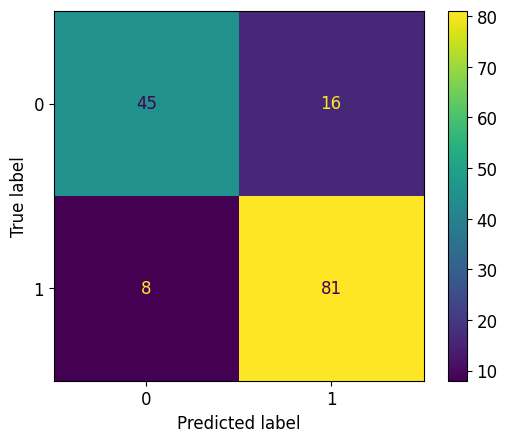

In [76]:
# Visualisation des prédictions
metrics.ConfusionMatrixDisplay.from_predictions(y_reservees, y_pred_final)
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

**Réponse :**

On remarque que les valeurs sont sensiblement les mêmes que celles de la dernière matrice de confusion, mais elles sont légèrement mieux, étant donné que les faux positifs et négatifs sont plus rares que précédemment. On remarque également que le modèle est très bon pour détecter les vrais positifs, ce qui fait qu'on peut imaginer s'en servir pour assiter la détection de problèmes médicaux. Dans ce cadre aussi, il faut notamment faire attention au nombre de faux négatifs, car ce sont ceux-ci qui mettent en danger les personnes à risque s'ils font trop confiance à ce modèle. Heureusement, ce chiffre-ci est le plus faible des quatre, mais reste non négligeable ; il faut donc manier cet outil avec précaution.

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

**Réponse :**

L'algorithme des K plus proches voisins, ainsi que de la forêt aléatoire, se prêtent bien à entrainer des classifieurs multiclasse. En revanche, la régression logistique est inadaptée à cet usage tel quel.

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

Meilleur K : 9
Pécision équilibrée: 0.6651677747779898


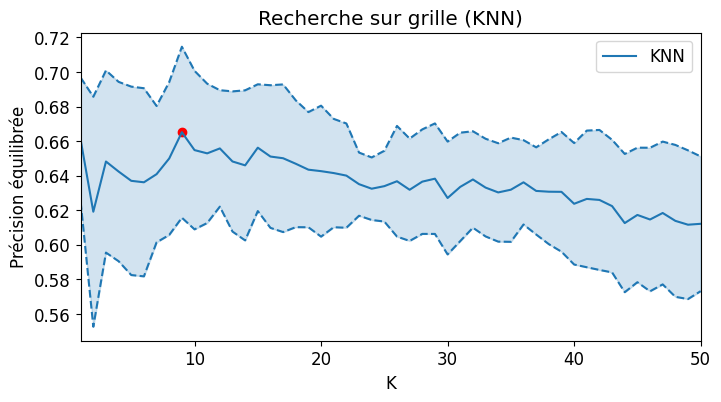

In [79]:
from sklearn import model_selection

# Définir la grille de valeurs de l'hyperparamètre K 
K = np.linspace(1, 50, 50, dtype=np.int64)

neigh = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(neigh, {'n_neighbors': K}, 
                                    cv=10, # on utilise 10 folds
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_scaled, y_train)



## Affichage sur un graphique des résultats

plt.figure(figsize=(8, 4))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.plot(grid.cv_results_['param_n_neighbors'], precision, 
             label="KNN", color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(K, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

plt.scatter(grid.best_params_['n_neighbors'], grid.best_score_, marker = 'o', c='red')
print(f"Meilleur K : {grid.best_params_['n_neighbors']}")
print(f"Pécision équilibrée: {grid.best_score_}")

BestKNN = grid.best_estimator_

# Mise en forme
plt.xlabel("K")
plt.ylabel("Précision équilibrée")
plt.xlim([K[0], K[-1]])
plt.title("Recherche sur grille (KNN)")
plt.legend(loc='best')
plt.show()

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

In [80]:
BestKNN.fit(X_scaled,y_train)

KNeighborsClassifier(n_neighbors=np.int64(9))

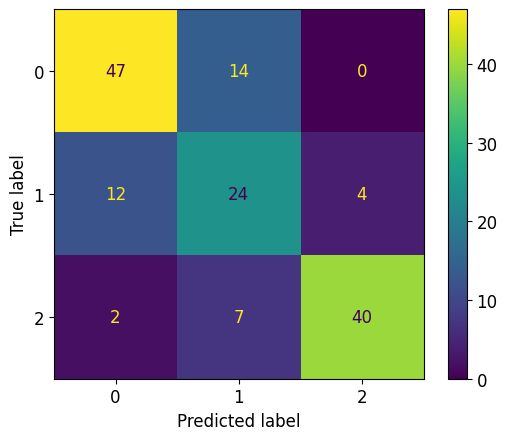

In [82]:
y_pred_multiclass = BestKNN.predict(X_reservees_scaled)

y_reservees_multiclass = np.array(df_reservees['Risque'], dtype='int')

metrics.ConfusionMatrixDisplay.from_predictions(y_reservees_multiclass, y_pred_multiclass)
plt.show()